# Cliquet
Price a Cliquet using different models. Cliquets are frequently used as hedges for annuities with caps and floors.
For a definition of the payoff, and the dataclass to construct a cliquet timetable, see [qablet_contracts.eq.cliquet.Accumulator](https://qablet.github.io/qablet-contracts/examples/equity_cliquet)

In [1]:
import pandas as pd
from finmc.models.heston import HestonMC
from qablet.base.mc import MCPricer
from qablet_contracts.eq.cliquet import Accumulator

from data.spx_2005_09_15 import basic_info, dataset
from src.model.localvol import LVMC
from src.model.rbergomi import rBergomiMC

### Contract
Create a Cliquet Contract fixing bi-monthly.

In [2]:
prc_dt = basic_info["prc_dt"]
exp_dt = prc_dt + pd.DateOffset(years=1)

fix_dates = pd.bdate_range(prc_dt, exp_dt, freq="2BME")
global_floor = 0.0
local_floor = -0.03
local_cap = 0.05
timetable = Accumulator(
    "USD",
    "SPX",
    fix_dates,
    global_floor,
    local_floor,
    local_cap,
    state={"S_PREV": 1.0},
).timetable()

print(timetable["events"].to_pandas())

                       time   op  quantity    unit track
0 2005-09-30 00:00:00+00:00  NaN       0.0   start   NaN
1 2005-11-30 00:00:00+00:00  NaN       0.0  addfix   NaN
2 2006-01-31 00:00:00+00:00  NaN       0.0  addfix   NaN
3 2006-03-31 00:00:00+00:00  NaN       0.0  addfix   NaN
4 2006-05-31 00:00:00+00:00  NaN       0.0  addfix   NaN
5 2006-07-31 00:00:00+00:00  NaN       0.0  addfix   NaN
6 2006-07-31 00:00:00+00:00    >       0.0     USD      
7 2006-07-31 00:00:00+00:00    +     100.0     ACC      


### Compare Models
Create the models.

In [3]:
models = {
    "Localvol": MCPricer(LVMC),
    "Heston": MCPricer(HestonMC),
    "rBergomi": MCPricer(rBergomiMC),
}

Get Price and Execution times

In [4]:
import time

for model_name, model in models.items():
    start_time = time.time()
    price, _ = model.price(timetable, dataset)
    end_time = time.time()
    print(
        f"{model_name:10} price: {price:6.3f}, time: {end_time - start_time:6.2f}"
    )

Localvol   price:  8.363, time:   0.76
Heston     price:  8.583, time:   0.32
rBergomi   price:  8.955, time:   6.25


Create a series of cliques with different global floors.

In [5]:
timetables = []
notional = 100
global_floors = [gf * notional for gf in [-0.02, 0.0, 0.02, 0.04]]
for global_floor in global_floors:
    timetable = Accumulator(
        "USD",
        "SPX",
        fix_dates,
        global_floor,
        local_floor,
        local_cap,
        notional=notional,
        state={"S_PREV": 1.0},
    ).timetable()
    timetables.append(timetable)

Run this series through each model.

In [6]:
df = pd.DataFrame({"global floor": global_floors})
for model_name, model in models.items():
    df[model_name] = [
        model.price(timetable, dataset)[0] for timetable in timetables
    ]
    print(f"{model_name} done")
    print(df)

Localvol done
   global floor  Localvol
0          -2.0  8.230479
1           0.0  8.362580
2           2.0  8.600019
3           4.0  8.994987
Heston done
   global floor  Localvol    Heston
0          -2.0  8.230479  8.473099
1           0.0  8.362580  8.582766
2           2.0  8.600019  8.784274
3           4.0  8.994987  9.121477
rBergomi done
   global floor  Localvol    Heston  rBergomi
0          -2.0  8.230479  8.473099  8.867586
1           0.0  8.362580  8.582766  8.954715
2           2.0  8.600019  8.784274  9.122660
3           4.0  8.994987  9.121477  9.413786


## Plot

<Axes: title={'center': 'Cliquet'}, xlabel='global floor'>

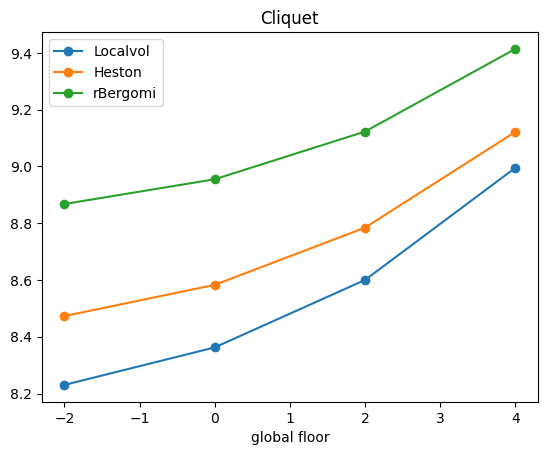

In [7]:
df.columns
df.plot(
    x="global floor",
    y=models.keys(),
    marker="o",
    title="Cliquet",
)